In [1]:
# Import
import numpy as np
import time
import scipy
import scipy.integrate

import matplotlib
import matplotlib.pyplot as plt

In [2]:
''' Set some parameter values. '''
try:
  # To extract parameters from a solver file (needs appropriate imports)
  solver_from = lambda i: readwritedatafiles.read_data_file(
    f"verification_conduit_p_{i}.pkl")
  solver = solver_from(0)
  print("Solver loaded. Extracting parameters. ")
  c_v = solver.physics.Gas[1]["c_v"]
  c_p = solver.physics.Gas[1]["c_p"]
  R = solver.physics.Gas[1]["R"]
  # Magma properties (version check)
  c_m = solver.physics.Liquid["c_m"]
  K = solver.physics.Liquid["K"]
  p0 = solver.physics.Liquid["p0"]
  rho0 = solver.physics.Liquid["rho0"]
  k = solver.physics.Solubility["k"]
  n = solver.physics.Solubility["n"]
except:
  # Solver probably not found; use default values
  c_v, c_p, R = (1826.6237513873475, 2288.0, 461.3762486126526)
  c_m, K, p0, rho0 = (3000.0, 10000000000.0, 5000000.0, 2500.0)
  k, n = (5e-06, 0.5)
  print("Using default parameters in notebook. ")


Using default parameters in notebook. 


In [3]:
''' Borrow/extend deformation energy class from physics. ''' 

class DeformationEnergyFn():
  ''' Computes specific deformation energy as a function.
  Also contains useful subfunctions for decomposing the deformation en.'''
  def __init__(self, rho0, K, p0, p1):
    self.rho0 = rho0
    self.K = K
    self.p0 = p0
    self.p1 = p1
    self.rho1 = rho0*(1 + (p1 - p0) / K)

  def __call__(self, p):
    ''' Specific deformation energy (units m^2 / s^2). '''
    return self.strain_energy(p) + self.prestress_energy(p) - self.prestress_energy(self.p1)

  def rho(self, p):
    return self.rho0*(1 + (p - self.p0) / self.K)

  def drhodp(self):
    ''' drho/ dp where rho is density. '''
    return self.rho0 / self.K

  def dvdp(self, p):
    ''' dv / dp where v is specific volume. '''
    return -1.0 / self.rho(p)**2 * self.drhodp()

  def strain_energy(self, p):
    ''' Strain energy as integral of (p_1-p) dv'''
    u = (self.p1-p)/(p+self.K-self.p0)
    return self.K/self.rho0 * (u - np.log(1 + u))

  def prestress_energy(self, p):
    ''' Prestress work as integral of -p_1 dv '''
    return self.p1*(1/self.rho1 - 1/(self.rho0 + self.rho0/self.K*(p-self.p0)))

  def strain_energy_quadrapprox(self, p):
      ''' Quadratic approximation of strain energy near p_1. '''
      return 0.5*self.K/self.rho0*(p-self.p1)**2.0 / ((self.p1+self.K-self.p0))**2.0

  def linearized_strain(self, p):
      return self.K*(p-self.p1)/ ((self.p1+self.K-self.p0))**2.0

  def ddp(self, p):
    ''' Derivative of total deformation energy with respect to pressure.
    Units of specific volume, (specific energy) / (volumetric energy).
    Conjugate to pressure. This can be shown using
    d/dp int(p dv) = d/dp int p dv/dp dp = p * dv/dp.
    ''' 
    return p / self.rho(p)**2 * (self.rho0 / self.K)

# Define deformation energy function for current magma
edf_m = DeformationEnergyFn(rho0, K, p0, p0)

In [4]:
''' Define general thermo functions.
Currently: magma (no crystals), dissolved water, exsolved water as an ideal gas.
'''

def h_wv(T):
  ''' Specific enthalpy of ideal gas water phase. '''
  return c_p * T

def rho_m(p):
  ''' Phasic density of magma phase. '''
  return rho0 * (1 + (p-p0)/K)

def v_m(p):
  ''' Specific volume of magma phase. '''
  return 1.0 / rho_m(p)

def h_m(p, T):
  ''' Specific enthalpy of magma phase. '''
  return c_m * T + edf_m(p)

def x_sat(p):
  ''' Saturation mass concentration. '''
  # Henry's law
  return k * np.abs(p) ** n

def ddp_x_sat(p):
  ''' Derivative of saturation mass concentration w.r.t. pressure. '''
  # d/dp Henry's law
  return n * k * np.abs(p) ** (n-1.0)

def sat_indicator(p, ywt):
  ''' Indicator function for saturated state. '''
  return float(x_sat(p) <= ywt / (1-ywt)) if ywt < 1.0 else float(True)

def y_wv_eq(p, ywt):
  ''' Water volume fraction at equilibrium. ''' 
  return np.clip(1 - (1+x_sat(p))*(1-ywt),0,1)

def dy_wv_eq_dp(p, ywt):
  ''' Derivative of water volume fraction w.r.t. pressure. '''
  return (ywt-1) * ddp_x_sat(p) * sat_indicator(p,ywt)

def v_wv(p, T):
  ''' Specific volume of ideal gas water vapour. ''' 
  return R*T/p

def dvw_dp_T(p, T):
  ''' Partial derivative of water specific volume v_w w.r.t pressure at constant T. Used in chain rule.'''
  return -R*T/p**2

def dvw_dT_p(p):
  ''' Partial derivative of water specific volume v_w w.r.t T at constant p. Used in chain rule.'''
  return R/p

def dvm_dp(p):
  ''' Derivative of magma specific volume v_w w.r.t pressure.'''
  return -1.0 / rho_m(p)**2 * rho0 / K

def v_mix(p, T, y):
  ''' Mixture specific volume ''' 
  return y * v_wv(p, T) + (1 - y) * v_m(p)

def T_h(p, h, y):
  ''' Temperature as a function of mixture enthalpy. '''
  c_p_mix = y * c_p + (1 - y) * c_m
  # Sensible temperature-dependent part of enthalpy
  hs_T = h - (1.0 - y) * (edf_m(p) + p * v_m(p))
  return hs_T / c_p_mix

def dT_dp(p, h, y):
  ''' Partial derivative of T(p, h, y).'''
  c_p_mix = y * c_p + (1 - y) * c_m
  return - (1.0 - y) / c_p_mix * (edf_m.ddp(p) + v_m(p) + p * dvm_dp(p))

def dT_dh(p, h, y):
  ''' Partial derivative of T(p, h, y).'''
  return 1.0 / (y * c_p + (1 - y) * c_m)

def dT_dy(p, T, y):
  ''' Partial derivative of T(p, h, y). Note that T is passed in argument.''' 
  c_p_mix = y * c_p + (1 - y) * c_m
  return (edf_m(p) + p * v_m(p) - (c_p - c_m) * T) / c_p_mix

def vf_g(p, T, y):
  ''' Ideal vapour volume fraction in binary mixture. '''
  return y * v_wv(p, T) / v_mix(p, T, y)

def h_mix(p, T, y):
  ''' Mixture enthalpy. '''
  return y * c_p * T + (1 - y) * (c_m * T + edf_m(p) + p * v_m(p))

In [5]:
''' Define coefficient matrix function for n=3 system of ODEs. '''
def A(p, h, y, j0):
  ''' Coefficient matrix. '''
  A = np.zeros((3,3))

  # Evaluate mixture state
  T = T_h(p, h, y)
  v = v_mix(p, T, y)
  # Evaluate partials of mixture specific volume
  dv_dp = y * (R / p * dT_dp(p, h, y) - R * T / p**2) + (1 - y) * dvm_dp(p)
  dv_dh = y * R / p * dT_dh(p, h, y)
  dv_dy = (v_wv(p, T) - v_m(p)) + y * R / p * dT_dy(p, T, y)
  
  A[0,:] = [1+j0**2 * dv_dp, j0**2 * dv_dh, j0**2 * dv_dy]
  A[1,:] = [v, -1, 0]
  A[2,:] = [0, 0, j0*v]

  return A

In [49]:
''' Define eigenvalues of A '''
def eigA(p, h, y, j0):
  '''The eigenvalues are 
    u,
  which transports the chemical state (dy/dx), and the pair
    0.5 * j0^2 * (dv/dp)_{h,y} + 0.5 * sqrt((j0^2 dv/dp)^2 + 4(1 + j0^2 dv/dp + v j0^2 (dv/dh)) ),
    0.5 * j0^2 * (dv/dp)_{h,y} - 0.5 * sqrt((j0^2 dv/dp)^2 + 4(1 + j0^2 dv/dp + v j0^2 (dv/dh)) ).
  This conjugate pair replaces the usual isentropic sound speed eigenvalues.
  ''' 
  # Evaluate mixture state
  T = T_h(p, h, y)
  v = v_mix(p, T, y)
  # Evaluate partials of mixture specific volume
  dv_dp = y * (R / p * dT_dp(p, h, y) - R * T / p**2) + (1 - y) * dvm_dp(p)
  dv_dh = y * R / p * dT_dh(p, h, y)
  
  # Compute eigenvalues
  u = j0 * v
  _q1 = j0**2 * dv_dp
  _q2 = np.sqrt(_q1**2 + 4 * (1 + _q1 + v * j0**2 * dv_dh))
  l1 = 0.5*(_q1 - _q2)
  l2 = 0.5*(_q1 + _q2)

  return np.array([u, l1, l2])

In [6]:
''' More chemical equilibrium thermodynamics. Currently unused. '''

class Equilibrium():
  def vf_g_eq(p, T, ywt):
    ''' Gas volume fraction in two-phase mixture.'''
    return y_wv_eq(p, ywt) * v_wv(p, T) / v_mix_eq(p, T, ywt)

  def v_mix_eq(p, T, ywt):
    ''' Mixture specific volume at chemical equilibrium. '''
    y = y_wv_eq(p, ywt)
    return y * v_wv(p, T) + (1-y) * v_m(p)

  def rho_mix_eq(p, T, ywt):
    ''' Mixture density at chemical equilibrium. '''
    return 1.0/v_mix_eq(p, T, ywt)

  def dTdp_eq(p, T, ywt):
    ''' Isenthalpic derivative of temperature w.r.t. pressure along equilibrium conditions. '''
    y = y_wv_eq(p, ywt)
    c_v_mix = y * c_v + (1-y) * c_m
    # Compute pressure-dependent specific enthalpy and chemical change
    _dhdp = (1 - y) * v_m(p) + (h_wv(T) - h_m(p,T)) * (
      (ywt-1) * ddp_x_sat(p) * sat_indicator(p,ywt))
    return -_dhdp / c_v_mix 

  def dv_dp_eq(p, T, ywt):
    ''' Mixture dv/dp at constant enthalpy, chemical equilibrium. Invokes the chain rule. '''
    # Compute exsolution-related volume change
    chemical = (v_wv(p,T) - v_m(p)) * dy_wv_eq_dp(p, ywt)
    # Compute expansion-related volume change 
    y = y_wv_eq(p, ywt)
    expansion = y * (dvw_dp_T(p, T) + dvw_dT_p(p) * dTdp_eq(p, T, ywt)) \
      + (1 - y) * (dvm_dp(p))
    return chemical + expansion

In [84]:
''' Define ODE system. '''

# Water mass fraction (uniformly applied in conduit)
ywt          = 0.03
# Critical volume fraction
crit_volfrac = 0.7
# Exsolution timescale
tau_d        = 1.0
# Viscosity (Pa s)
mu           = 5e8
# Conduit radius (m)
conduit_rad  = 10
# Chamber conditions
p_chamber    = 50e6
T0           = 800+273.15
# Mass flux (uniform in conduit; equal to rho * u and depends on outlet pressure)
rho_in = rho0
u_in   = 1.0
j0     = rho_in * u_in
# Set depth of conduit inlet (0 is surface)
x0 = -4000
# Number of evaluation points for ODE solver (does not affect ODE numerics much)
N_x = 200

''' Define solver for (p,h,y)(x), using current workspace param values as default. '''
def solve_p(ywt=ywt, crit_volfrac=crit_volfrac, mu=mu, tau_d=tau_d,
  conduit_rad=conduit_rad, p_chamber=p_chamber,
  T0=T0, j0=j0, x0=x0, N_x=N_x):

  h_chamber = h_mix(p_chamber, T0, y_wv_eq(p_chamber, ywt))

  ''' Define momentum source (using captured parameters). '''
  # Define gravity momentum source
  g = -9.8
  F_grav = lambda rho: rho * g
  # Define friction momentum source
  F_fric = lambda u, is_frag: -8.0*mu/conduit_rad**2 * u * (1.0-is_frag)
  # Define fragmentation condition
  is_frag = lambda p, T, y: float(vf_g(p, T, y) > crit_volfrac)
  # Define ODE momentum source term sum in terms of density rho
  F_rho = lambda p, T, y, rho: F_grav (rho) + F_fric(j0 / rho, is_frag(p, T, y))

  ''' Define water vapour mass fraction source (using captured parameters). '''
  Y = lambda p, y: 1 / tau_d * (
    ywt - y - x_sat(p)/(1 + x_sat(p))) * (1-y) / (1+y)
  
  ''' Set source term vector. '''
  def F(q):
    # Unpack q of size (3,1)
    p, h, y = q
    F = np.zeros((3,1))
    # Compute mixture temperature
    T = T_h(p, h, y)
    # Compute source vector
    F[0] = F_rho(p, T, y, 1.0/v_mix(p, T, y)) 
    F[2] = Y(p, y)
    return F

  ''' Set ODE RHS A^{-1} F '''
  def RHS(x, q):
    # Does not use eigcheck use event handling in ODE solver instead
    # Evaluate mass matrix A
    A_evald = A(*q, j0)
    # Solve for RHS ode
    return np.linalg.solve(A_evald, F(q)).flatten()

  def AinvRHS(x, q):
    ''' Precomputed A^{-1} f for speed.
    Uses block triangular inverse of
      [A b]^{-1}  = [A^{-1}  z ]
      [  u]         [       1/u]
    applied to sparse RHS vector F.
    Use this instead of RHS for speed.
    '''
    
    # Unpack
    p, h, y = q
    # Compute dependents
    T     = T_h(p, h, y)
    dv_dp = y * (R / p * dT_dp(p, h, y) - R * T / p**2) + (1 - y) * dvm_dp(p)
    dv_dh = y * R / p * dT_dh(p, h, y)
    dv_dy = (v_wv(p, T) - v_m(p)) + y * R / p * dT_dy(p, T, y)
    v     = v_mix(p, T, y) 
    u     = j0 * v
    # Compute first column of A^{-1}:(2,1)
    a1 = np.array([1, v]) / (1+j0**2 * dv_dp + v * j0**2 * dv_dh)
    # Compute z == -A^{-1} * b / u
    z = -j0**2 * dv_dy / u * a1
    return Y(p, y) * np.array([*z, 1/u]) + F_rho(p, T, y, 1.0/v) * np.array([*a1, 0])
  
  def RHS_reduced(x, q):
    ''' Reduced-size system for j0 == 0 case. (2x1 instead of 3x1). '''
    p, h = q
    F = np.zeros((2,1))
    # Equilibrium water vapour
    y = y_wv_eq(p, ywt)
    # Compute mixture temperature
    T = T_h(p, h, y)
    v = v_mix(p, T, y)
    # Compute source vector with idempotent A^{-1} = A premultiplied
    F[0] = 1
    F[1] = v
    F *= F_rho(p, T, y, 1.0/v_mix(p, T, y)) 
    return F.flatten()
  
  ''' Define postprocessing eigenvalue checker '''  
  class EventChoked():
    def __init__(self):
      self.terminal = True
      self.sonic_tol = 1e-7
    def __call__(self, t, q):
      # Compute equivalent condition to conjugate pair eigenvalue == 0
      # Note that this does not check the condition u == 0 (or j0 == 0).
      p, h, y = q
      T = T_h(p, h, y)
      dv_dp = y * (R / p * dT_dp(p, h, y) - R * T / p**2) + (1 - y) * dvm_dp(p)
      dv_dh = y * R / p * dT_dh(p, h, y)
      return j0**2 * (dv_dp + v_mix(p, T, y) * dv_dh) + 1.0 - self.sonic_tol
      # Default eigenvalue computation
      return np.abs(np.linalg.eigvals(A(*q, j0))).min() - self.sonic_tol
  event_choked = EventChoked()

  # Set chamber (inlet) condition (p, h, y) with y = y_eq at pressure
  q0 = np.array([p_chamber, h_chamber, y_wv_eq(p_chamber, ywt)])

  # Call ODE solver
  x_mesh = np.linspace(x0,0,N_x)
  if j0 > 0:
    soln = scipy.integrate.solve_ivp(AinvRHS, (x0,0), q0, t_eval=x_mesh, method="BDF", events=event_choked)
    # Output solution
    soln_state = soln.y
  else: # Exsolution length scale u * tau_d -> 0
    # Exact zero flux: use reduced (equilibrium chemistry) system
    soln = scipy.integrate.solve_ivp(RHS_reduced, (x0,0), q0[:-1], t_eval=x_mesh, method="BDF")
    # Augment output solution with y at equilibrium
    soln_state = np.vstack((soln.y, y_wv_eq(soln.y[0,:], ywt)))

  # Compute eigenvalues at the final t
  eigvals_t_final = eigA(*soln_state[:,-1], j0)

  return soln.t, soln_state, (soln, eigvals_t_final)


With the system of ODEs defined, we can plug in various values of mass flux `j_0 = rho_0 * u_0`, which is constant in the steady state. The system of ODEs has form `A * dq/dx = f` in vector form. If `A` is singular, there is a problem (this corresponds to either the system degenerating to the static case when `j_0 == 0`, or reaching the sonic point---flow choking). 

In the following, we find the maximum value of `j_0` attainable before this sonic point is reached in the domain. This corresponds to the maximum discharge rate of the system, given a fixed value of (constant) viscosity, conduit length & radius, fragmentation criterion, total water fraction, exsolution rate, chamber pressure, and chamber temperature.

Pressure p(x) for j0 = 0 solver (2 ODEs) and j0 = small number solver (3 ODEs).


Text(0, 0.5, 'p (bar)')

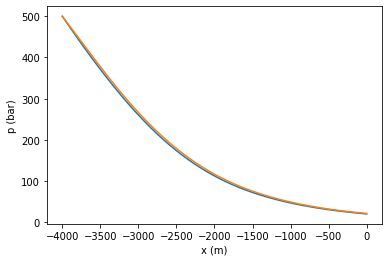

In [90]:
# Test equilibrium backend
_x1, (_p1, _h1, _y1), _ = solve_p(j0=1e-3)
_x0, (_p0, _h0, _y0), _ = solve_p(j0=0)
plt.plot(_x1, _p1/1e5)
plt.plot(_x0, _p0/1e5)
print("Pressure p(x) for j0 = 0 solver (2 ODEs) and j0 = small number solver (3 ODEs).")
plt.xlabel("x (m)")
plt.ylabel("p (bar)")

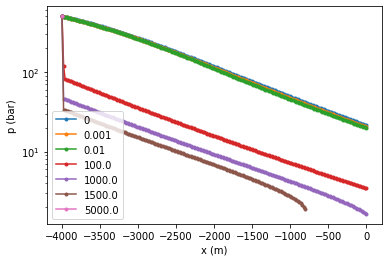

In [82]:
''' Plot pressure as function of x, for several values of j0. '''
view_idx = 0
j0_range = [0, 1e-3, 1e-2, 1e2, 1e3, 1.5e3, 5e3]
for j0 in j0_range:
  _t, _z, outs = solve_p(j0=j0)
  plt.semilogy(_t, _z[view_idx,:]/1e5,'.-')

plt.xlabel("x (m)")
plt.ylabel("p (bar)")
l = plt.legend(j0_range)

In [54]:
''' Define mapping from mass flux j0 to lambda_min(x = 0) ''' 
def eigmin_top(j0, *args, **kwargs):
  ''' Returns min abs eigval at top, or negative value if the matrix
  is singular at depth.''' 
  _t, _z, outs = solve_p(j0=j0, *args, **kwargs)
  return -1e-1 if len(outs[0].t_events[0]) != 0 or not outs[0].success else \
    np.min(np.abs(outs[1]))

If the flow is choked before the top, -0.1 is plotted instead.


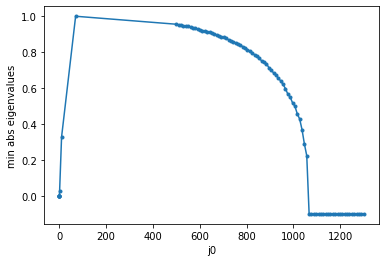

In [85]:
'''Plot the min abs eigenvalue at the top (x=0) for a range of mass flux j0. ''' 

j0_min = 1e-3 # Minimum value for j0 that is numerically stable
j0_low = 500  # Low value for j0 that is unchoked at vent
j0_range = [*np.logspace(-5, np.log10(j0_low), 10)[:-1], *np.linspace(j0_low, 1.3e3, 80)]

# Compute lambdas
lambdas = [eigmin_top(j0) for j0 in j0_range]
plt.plot(j0_range, lambdas, '.-')
plt.xlabel("j0")
plt.ylabel("min abs eigenvalues")
print("If the flow is choked before the top, -0.1 is plotted instead.")

In [86]:
''' Solve for maximum value of j_0 before choking. '''
j0_max = scipy.optimize.brenth(eigmin_top, 100, 5000)
# Establish range of j0 that does not choke
j0_range = (j0_min, j0_max)

States for highest mass flux at inlet


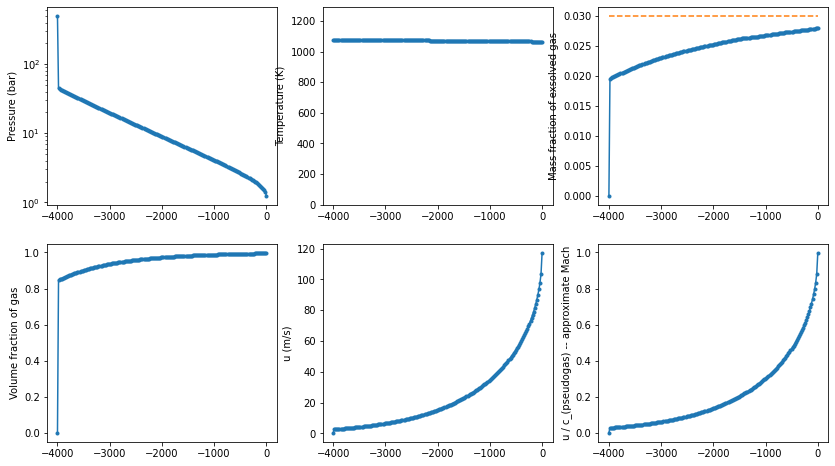

In [57]:
''' Plot several states for the maximal j_0 case. ''' 
# Plot lowest top pressure case
j0 = j0_max
_x, (_p, _h, _y), outs = solve_p(j0=j0_max)
# Post process solution
_T  = T_h(_p, _h, _y)
_vf = vf_g(_p, _T, _y)
_rho = 1.0 / v_mix(_p, _T, _y)
_u = j0 / _rho
Gamma = (_y * c_p + (1-_y) * c_m) / (_y * c_v + (1-_y) * c_m)
_c_approx = np.sqrt(_y * Gamma * R * _T)

plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.semilogy(_x, _p/1e5, '.-')
plt.ylabel("Pressure (bar)")

plt.subplot(2,3,2)
plt.plot(_x, _T, '.-')
plt.ylim(bottom=0, top=_T.max()*1.2)
plt.ylabel("Temperature (K)")

plt.subplot(2,3,3)
plt.plot(_x, _y, '.-')
plt.plot(_x, ywt*np.ones_like(_y), '--')
plt.ylabel("Mass fraction of exsolved gas")

plt.subplot(2,3,4)
plt.plot(_x, _vf, '.-')
plt.ylabel("Volume fraction of gas")

plt.subplot(2,3,5)
plt.plot(_x, _u, '.-')
plt.ylabel("u (m/s)")

plt.subplot(2,3,6)
_c_approx = np.where(_c_approx > 1, _c_approx, np.sqrt(K/rho0))
plt.plot(_x, _u/_c_approx, '.-')
plt.ylabel("u / c_(pseudogas) -- approximate Mach")

print("States for highest mass flux at inlet")

In [58]:
''' Map dependence of top pressure as function of j0 for example case. ''' 

# Sample points with a visually nice distribution
j0_scan_range = [*np.logspace(np.log10(j0_range[0]), np.log10(j0_low), 20)[:-1],
  *np.linspace(j0_low, j0_range[1], 20)]
# Get top pressures
top_pressures = np.array([solve_p(j0=j0)[1][0][-1] for j0 in j0_scan_range])
# For plotting, set pressure range that results in choked flow
choked_pressures = np.array([0, np.min(top_pressures)])

Each value of mass flux corresponds to one value of vent pressure.
A shooting method can solve for the value of vent pressure, up to the minimum (choking) pressure.


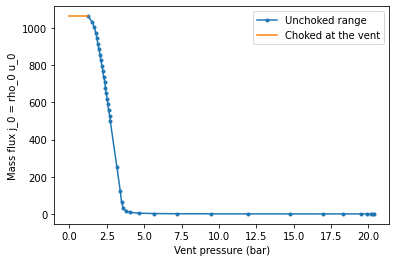

In [59]:
plt.plot(top_pressures/1e5, j0_scan_range, '.-')
plt.plot(choked_pressures/1e5, j0_range[1]*np.ones_like(choked_pressures), '-')
plt.legend(["Unchoked range", "Choked at the vent"])
plt.xlabel("Vent pressure (bar)")
plt.ylabel("Mass flux j_0 = rho_0 u_0")
print('''Each value of mass flux corresponds to one value of vent pressure.
A shooting method can solve for the value of vent pressure, up to the minimum (choking) pressure.''')

Below is the code that takes `p_vent` and model parameters and returns the solution [p(x), h(x), y(x)]. The function prints the flow state at the vent during calculation.

In [87]:
''' Driver for code in which user inputs top boundary pressure. 
Solves for the choking pressure and corresponding j0, and then solves
for j0 corresponding to the prescribed vent pressure if the pressure
is above the choking pressure but below the hydrostatic vent pressure.

Can be made faster by directly solving for the choking pressure, and
then checking if flow is choked at the computed j0.
'''
def solve_steady_state(p_vent, verbose=False,
  ywt=ywt, crit_volfrac=crit_volfrac, mu=mu, tau_d=tau_d,
  conduit_rad=conduit_rad, p_chamber=p_chamber,
  T0=T0, j0=j0, x0=x0, N_x=N_x):
  # Set j0 range for finding max 
  j0_min = 1e-3
  j0_max = 1e4
  # Define solve kernel that returns (x, (p, h, y), (soln, eigvals))
  solve_kernel = lambda j0: solve_p(ywt=ywt, crit_volfrac=crit_volfrac,
    mu=mu, tau_d=tau_d, conduit_rad=conduit_rad, p_chamber=p_chamber,
    T0=T0, j0=j0, x0=x0, N_x=N_x)
  # Define mapping j0 -> p_vent
  calc_vent_p  = lambda j0: solve_kernel(j0)[1][0][-1]

  ''' Get valid range of j0. ''' 
  print("Solving for j0 range. ")
  # Solve for maximum j0 that does not choke
  j0_max = scipy.optimize.brenth(lambda j0: eigmin_top(
    ywt=ywt, crit_volfrac=crit_volfrac, mu=mu, tau_d=tau_d,
    conduit_rad=conduit_rad, p_chamber=p_chamber,
    T0=T0, j0=j0, x0=x0, N_x=N_x
  ), j0_min, j0_max)
  # Establish range of j0 that does not choke
  j0_range = (j0_min, j0_max)
  
  ''' Get corresponding range of p. '''
  print("Solving for p range. ")
  # Compute max pressure (hydrostatic)
  p_max = calc_vent_p(j0_min)
  # Compute choking (minimum) vent pressure
  p_min = calc_vent_p(j0_max)

  ''' Check vent flow state for given p_vent, and solve for solution [p(x), h(x), y(x)]. '''
  if p_vent < p_min:
    # Choked case
    print("Choked at vent.")
    x, (p_soln, h_soln, y_soln), (soln, _) = solve_kernel(j0_max)
  elif p_vent > p_max:
    # Inconsistent pressure (exceeds hydrostatic pressure consistent with chamber pressure)
    print("Vent pressure is too high (reverse flow required to reverse pressure gradient).")
    x, (p_soln, h_soln, y_soln), soln = None, (None, None, None), None
  else:
    print("Subsonic flow at vent. Shooting method for correct value of j0.")
    j0 = scipy.optimize.brenth(lambda j0: calc_vent_p(j0) - p_vent, j0_min, j0_max)
    print("Solution j0 found. Computing solution.")
    # Compute solution at j0
    x, (p_soln, h_soln, y_soln), (soln, _) = solve_kernel(j0)

  if verbose:
    # Package extra details on calculation.
    calc_details = {
      "j0_min": j0_min,
      "j0_max": j0_max,
      "p_min": p_min,
      "p_max": p_max,
      "soln": soln,
    }
    return x, (p_soln, h_soln, y_soln), calc_details
  else:
    return x, (p_soln, h_soln, y_soln)

Solving for j0 range. 
Solving for p range. 
Subsonic flow at vent. Shooting method for correct value of j0.
Solution j0 found. Computing solution.
Vent pressure of numerical solution is 5.000045383148677 bar.


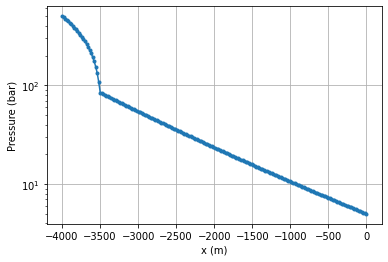

In [88]:
''' Code usage example '''
p_vent = 5e5
x, (p, h, y) = solve_steady_state(p_vent)
plt.semilogy(x, p/1e5, '.-')
plt.xlabel("x (m)")
plt.ylabel("Pressure (bar)")
plt.grid("both")
print(f"Vent pressure of numerical solution is {p[-1]/1e5} bar.")